# Figure S12

In [1]:
import numpy as np
import xarray as xr
from glob import glob
import gsw

import cosima_cookbook as cc

import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib.path as mpath
import matplotlib as mpl
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cmocean.cm as cmo

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40965,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:41237,Total threads: 4
Dashboard: /proxy/46213/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:46647,


In [3]:
import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

Read in data

In [4]:
path = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/isobath_aligned_transects/'

# temp
control = xr.open_dataset(path+'temp_control.nc')
ssp245 = xr.open_dataset(path+'temp_ssp245.nc')
ssp245mw = xr.open_dataset(path+'temp_ssp245mw.nc')
ssp585 = xr.open_dataset(path+'temp_ssp585.nc')
ssp585mw = xr.open_dataset(path+'temp_ssp585mw.nc')
control_temp = control.__xarray_dataarray_variable__.rename('temp')
ssp245_temp = ssp245.__xarray_dataarray_variable__.rename('temp')
ssp245mw_temp = ssp245mw.__xarray_dataarray_variable__.rename('temp')
ssp585_temp = ssp585.__xarray_dataarray_variable__.rename('temp')
ssp585mw_temp = ssp585mw.__xarray_dataarray_variable__.rename('temp')

# salt
control = xr.open_dataset(path+'salt_control.nc')
ssp245 = xr.open_dataset(path+'salt_ssp245.nc')
ssp245mw = xr.open_dataset(path+'salt_ssp245mw.nc')
ssp585 = xr.open_dataset(path+'salt_ssp585.nc')
ssp585mw = xr.open_dataset(path+'salt_ssp585mw.nc')
control_salt = control.__xarray_dataarray_variable__.rename('salt')
ssp245_salt = ssp245.__xarray_dataarray_variable__.rename('salt')
ssp245mw_salt = ssp245mw.__xarray_dataarray_variable__.rename('salt')
ssp585_salt = ssp585.__xarray_dataarray_variable__.rename('salt')
ssp585mw_salt = ssp585mw.__xarray_dataarray_variable__.rename('salt')

# density
control_sig1 = xr.open_dataset(path+'sigma1_control.nc')
ssp245_sig1 = xr.open_dataset(path+'sigma1_ssp245.nc')
ssp245mw_sig1 = xr.open_dataset(path+'sigma1_ssp245mw.nc')
ssp585_sig1 = xr.open_dataset(path+'sigma1_ssp585.nc')
ssp585mw_sig1 = xr.open_dataset(path+'sigma1_ssp585mw.nc')
control_sig1 = control_sig1.__xarray_dataarray_variable__.rename('sig1')
ssp245_sig1 = ssp245_sig1.__xarray_dataarray_variable__.rename('sig1')
ssp245mw_sig1 = ssp245mw_sig1.__xarray_dataarray_variable__.rename('sig1')
ssp585_sig1 = ssp585_sig1.__xarray_dataarray_variable__.rename('sig1')
ssp585mw_sig1 = ssp585mw_sig1.__xarray_dataarray_variable__.rename('sig1')

control_sig0 = xr.open_dataset(path+'sigma0_control.nc')
ssp245_sig0 = xr.open_dataset(path+'sigma0_ssp245.nc')
ssp245mw_sig0 = xr.open_dataset(path+'sigma0_ssp245mw.nc')
ssp585_sig0 = xr.open_dataset(path+'sigma0_ssp585.nc')
ssp585mw_sig0 = xr.open_dataset(path+'sigma0_ssp585mw.nc')
control_sig0 = control_sig0.__xarray_dataarray_variable__.rename('sig0')
ssp245_sig0 = ssp245_sig0.__xarray_dataarray_variable__.rename('sig0')
ssp245mw_sig0 = ssp245mw_sig0.__xarray_dataarray_variable__.rename('sig0')
ssp585_sig0 = ssp585_sig0.__xarray_dataarray_variable__.rename('sig0')
ssp585mw_sig0 = ssp585mw_sig0.__xarray_dataarray_variable__.rename('sig0')


Combine into one dataset. 

In [5]:
da_temp = xr.concat([control_temp, ssp245_temp, ssp245mw_temp, ssp585_temp, ssp585mw_temp], dim = 'expt')
da_temp = da_temp.assign_coords({'expt': ['control', 'ssp245', 'ssp245mw', 'ssp585', 'ssp585mw']})

da_salt = xr.concat([control_salt, ssp245_salt, ssp245mw_salt, ssp585_salt, ssp585mw_salt], dim = 'expt')
da_salt = da_salt.assign_coords({'expt': ['control', 'ssp245', 'ssp245mw', 'ssp585', 'ssp585mw']})

da_sig0 = xr.concat([control_sig0, ssp245_sig0, ssp245mw_sig0, ssp585_sig0, ssp585mw_sig0], dim = 'expt')
da_sig0 = da_sig0.assign_coords({'expt': ['control', 'ssp245', 'ssp245mw', 'ssp585', 'ssp585mw']})

da_sig1 = xr.concat([control_sig1, ssp245_sig1, ssp245mw_sig1, ssp585_sig1, ssp585mw_sig1], dim = 'expt')
da_sig1 = da_sig1.assign_coords({'expt': ['control', 'ssp245', 'ssp245mw', 'ssp585', 'ssp585mw']})

ds = xr.merge([da_temp, da_salt, da_sig0, da_sig1])

Define colour maps. 

In [6]:
from palettable.cmocean.diverging import Curl_11
from palettable.cmocean.diverging import Delta_11

cmap_D = plt.cm.get_cmap(Curl_11.mpl_colormap)
levels_D = np.arange(-0.4, 0.401, 0.02)
cmap_D.set_bad('k')

cmap_S = plt.cm.get_cmap(Delta_11.mpl_colormap)
levels_S = np.arange(-0.3, 0.31, 0.02)
cmap_S.set_bad('k')

Define plotting functions

In [7]:
def fig_setup(sim_labels):

    labels = ['A', 'B', 'C', 'D']
    
    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 11), height_ratios=[1, 1] )
    plt.subplots_adjust(wspace=0.05, hspace=0.25)

    # fig.delaxes(axes[2,0])
    # fig.delaxes(axes[2,1])
    
    for i, ax in enumerate(axes.flatten()):
        ax.set_facecolor('dimgrey')
        ax.text(0.02, 0.04, f'{labels[i]}',  c='k', fontsize=24, ha='left', fontweight='bold', transform=ax.transAxes)
        ax.text(0.97, 0.06, f'{np.tile(sim_labels, 2)[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)
    
    for i, ax in enumerate(axes[:,0]):
        ax.set_ylabel('Depth (m)')
    for i, ax in enumerate(axes[:,1]):
        ax.set_yticklabels([])

    axes[0,0].text(0.0, 1.04, 'Downstream of Cape Darnley (30-60\u00b0E)',  c='k', fontsize=16, fontweight='bold',transform=axes[0,0].transAxes)
    axes[1,0].text(0.0, 1.04, 'Cape Darnley DSW Formation Site (65-68\u00b0E)',  c='k', fontsize=16, fontweight='bold',transform=axes[1,0].transAxes)
    axes[-1,0].text(0.63, -0.2, 'Latitude (\u00b0 relative to 1000 m isobath)', c='k',fontsize=16, transform=axes[-1,0].transAxes)

    for i, ax in enumerate(axes[:1,:].flatten()):
        ax.set_ylim([1800, 0])
        ax.set_xlim([-1.8, 2.0])
    for i, ax in enumerate(axes[1:,:].flatten()):
        ax.set_ylim([1400, 0])
        ax.set_xlim([-1.1, 1.5]) 

    return fig, axes


def slice_longitude_and_take_mean(bound1, bound2, bound3, expt):
    ds_tmp = ds.sel(expt = expt)
    ds_mean = ds_tmp.where(((ds_tmp.xt_ocean < bound1) & (ds_tmp.xt_ocean >= bound2) | (ds_tmp.xt_ocean  > bound3)), np.nan).mean('xt_ocean')
    return ds_mean


def colorbar_vert(cb, axes, label):
    fs = 16
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax = cbaxes, orientation='vertical', extend='both')
    cbar.set_label(label, fontsize=fs, labelpad=6)
    return cbar


def plot_contours_experiment(ax, experiment, north_index, levels, bold_level):
    contour_colour = 'k'
    linewidth = 0.8
    linestyle = '-'

    cs = ax.contour(experiment.yt_isobath_rel[:north_index], experiment.st_ocean, experiment['sig0'][:, :north_index], 
                    levels=levels, colors=contour_colour, linewidths=linewidth, 
                    linestyles=linestyle, zorder=2)
    ax.clabel(cs, levels, use_clabeltext=True, fontsize=10, zorder=2)

    cs = ax.contour(experiment.yt_isobath_rel[:north_index], experiment.st_ocean, experiment['sig0'][:, :north_index], 
                    levels=[bold_level], colors=contour_colour, linewidths=2, 
                    linestyles=linestyle, zorder=3)
    ax.clabel(cs, [bold_level], use_clabeltext=True, fontsize=10, zorder=3)
    
    return 


def plot_contours_control(axes, control, north_index, levels, bold_level):
    contour_colour = 'grey'
    linewidth = 1.4
    linestyle = '--'
    
    for i, ax in enumerate(axes.flatten()):
        cs = ax.contour(control.yt_isobath_rel[:north_index], control.st_ocean, control['sig0'][:,:north_index], 
                        levels=levels, colors=contour_colour, linewidths=linewidth, 
                        linestyles=linestyle, zorder=2)
        ax.clabel(cs, levels, use_clabeltext=True, fontsize=10, zorder=2)
        cs = ax.contour(control.yt_isobath_rel[:north_index], control.st_ocean, control['sig0'][:,:north_index], 
                        levels=[bold_level], colors=contour_colour, linewidths=2.5, 
                        linestyles=linestyle, zorder=2)
        ax.clabel(cs, [bold_level], use_clabeltext=True, fontsize=10, zorder=2)

    return


def plot_contours_control_b(ax, control, north_index, levels, bold_level):
    contour_colour = 'grey'
    linewidth = 1.4
    linestyle = '--'

    cs = ax.contour(control.yt_isobath_rel[:north_index], control.st_ocean, control['sig0'][:,:north_index], 
                    levels=levels, colors=contour_colour, linewidths=linewidth, 
                    linestyles=linestyle, zorder=2)
    ax.clabel(cs, levels, use_clabeltext=True, fontsize=10, zorder=2)
    cs = ax.contour(control.yt_isobath_rel[:north_index], control.st_ocean, control['sig0'][:,:north_index], 
                    levels=[bold_level], colors='w', linewidths=2.5, 
                    linestyles=linestyle, zorder=2)
    ax.clabel(cs, [bold_level], use_clabeltext=True, fontsize=10, zorder=2)

    return


def plot_contours_control_c(ax, control, north_index, levels, bold_level):
    contour_colour = 'grey'
    linewidth = 1.4
    linestyle = '--'

    cs = ax.contour(control.yt_isobath_rel[:north_index], control.st_ocean, control['sig0'][:,:north_index], 
                    levels=levels, colors=contour_colour, linewidths=linewidth, 
                    linestyles=linestyle, zorder=2)
    ax.clabel(cs, levels, use_clabeltext=True, fontsize=10, zorder=2)
    cs = ax.contour(control.yt_isobath_rel[:north_index], control.st_ocean, control['sig0'][:,:north_index], 
                    levels=[bold_level], colors=contour_colour, linewidths=2.5, 
                    linestyles=linestyle, zorder=2)
    ax.clabel(cs, [bold_level], use_clabeltext=True, fontsize=10, zorder=2)

    return


def plot_contours_control_d(ax, control, north_index, levels, bold_level):
    contour_colour = 'w'
    linewidth = 1.4
    linestyle = '--'
    
    cs = ax.contour(control.yt_isobath_rel[:north_index], control.st_ocean, control['sig0'][:,:north_index], 
                    levels=levels, colors=contour_colour, linewidths=linewidth, 
                    linestyles=linestyle, zorder=2)
    ax.clabel(cs, levels, use_clabeltext=True, fontsize=10, zorder=2)
    cs = ax.contour(control.yt_isobath_rel[:north_index], control.st_ocean, control['sig0'][:,:north_index], 
                    levels=[bold_level], colors=contour_colour, linewidths=2.5, 
                    linestyles=linestyle, zorder=2)
    ax.clabel(cs, [bold_level], use_clabeltext=True, fontsize=10, zorder=2)

    return
    

Plot figure

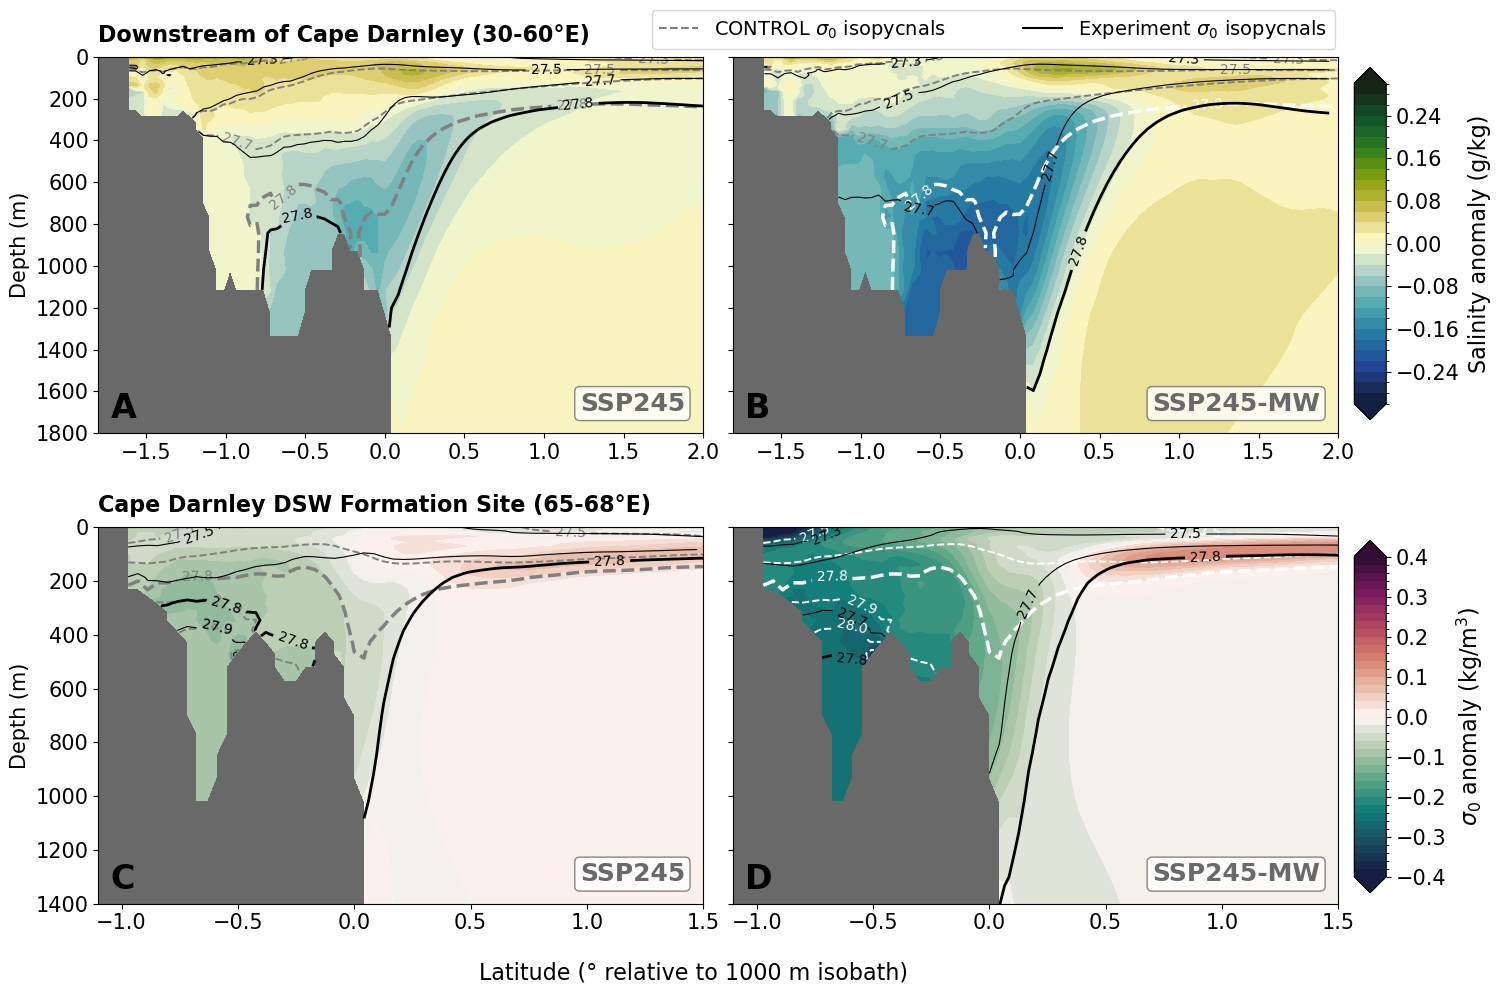

In [8]:
sim_labels = ['SSP245', 'SSP245-MW',]

fig, axes = fig_setup(sim_labels)

### --- Downstream of Prydz Bay --- ###
lon1, lon2, lon3 = 60, 30, 80
control_tmp = slice_longitude_and_take_mean(lon1, lon2, lon3, 'control')
expt_tmp = slice_longitude_and_take_mean(lon1, lon2, lon3, 'ssp245')
exptmw_tmp = slice_longitude_and_take_mean(lon1, lon2, lon3, 'ssp245mw')

# Plot density anomaly
axes[0,0].contourf(control_tmp.yt_isobath_rel, control_tmp.st_ocean, expt_tmp['salt'] - control_tmp['salt'],
                   cmap=cmap_S, norm=mpl.colors.BoundaryNorm(levels_S, ncolors=cmap_S.N, clip=False), 
                   levels=levels_S, extend='both')
cbS = axes[0,1].contourf(control_tmp.yt_isobath_rel, control_tmp.st_ocean, exptmw_tmp['salt'] - control_tmp['salt'],
                         cmap=cmap_S, norm=mpl.colors.BoundaryNorm(levels_S, ncolors=cmap_S.N, clip=False), 
                         levels=levels_S, extend='both')

# Add colorbar
cbar = colorbar_vert(cbS, [0.91, 0.55, 0.02, 0.32], 'Salinity anomaly (g/kg)')

# Add density contours
contour_levels = [27.3, 27.5, 27.7, 27.9]
plot_contours_control_c(axes[0, 0], control_tmp, -250, contour_levels, [27.80])
plot_contours_control_b(axes[0, 1], control_tmp, -250, contour_levels, [27.80])
plot_contours_experiment(axes[0, 0], expt_tmp, -250, contour_levels, [27.80])
plot_contours_experiment(axes[0, 1], exptmw_tmp, -260, contour_levels, [27.80])


### --- Prydz Bay --- ###
lon1, lon2, lon3 = 68, 65, 80
control_tmp = slice_longitude_and_take_mean(lon1, lon2, lon3, 'control')
expt_tmp = slice_longitude_and_take_mean(lon1, lon2, lon3, 'ssp245')
exptmw_tmp = slice_longitude_and_take_mean(lon1, lon2, lon3, 'ssp245mw')

# Plot density anomaly
axes[1,0].contourf(control_tmp.yt_isobath_rel, control_tmp.st_ocean, expt_tmp['sig0'] - control_tmp['sig0'],
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D, ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')
cbD = axes[1,1].contourf(control_tmp.yt_isobath_rel, control_tmp.st_ocean, exptmw_tmp['sig0'] - control_tmp['sig0'],
                         cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D, ncolors=cmap_D.N, clip=False), 
                         levels=levels_D, extend='both')

# Add density contours
contour_levels = [27.3, 27.5, 27.7, 27.9, 28.0, 28.1, 28.2, ]
plot_contours_control_c(axes[1, 0], control_tmp, -255, contour_levels, [27.80])
plot_contours_control_d(axes[1, 1], control_tmp, -255, contour_levels, [27.80])
plot_contours_experiment(axes[1, 0], expt_tmp, -250, contour_levels, [27.80])
plot_contours_experiment(axes[1, 1], exptmw_tmp, -260, contour_levels, [27.80])

# Add colorbar
cbar = colorbar_vert(cbD, [0.91, 0.12, 0.02, 0.32], '$\sigma_0$ anomaly (kg/m$^3$)')

# Add contour legend
line1 = Line2D([0], [0], color='grey', linestyle='--')
line2 = Line2D([0], [0], color='k', linestyle='-')
legend_labels = [f'CONTROL $\sigma_0$ isopycnals', f'Experiment $\sigma_0$ isopycnals']
axes[0, 0].legend([line1, line2], legend_labels, bbox_to_anchor=[2.06, 1.15], 
                  loc='upper right', fontsize=14, ncols=4, columnspacing=4, )

# # Save figure
# fig.savefig('../figs/SuppFig_DSW_density_changes.jpg', dpi=300, bbox_inches='tight')

plt.show()